<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/training_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --quiet pzflow corner

In [1]:
import jax.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from pzflow import Flow
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling

## Loading the data

Assuming a fiducial underlying galaxy catalog, we use `OpSim` to generate observed galaxy catalogs under different observing strategies.

In [2]:
!wget https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
!tar -xzf for_malz_and_lanusse.tar.gz
!mv for_malz_and_lanusse dataset

--2021-04-02 11:52:02--  https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.80, 216.58.217.48, 216.58.193.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35901537 (34M) [application/gzip]
Saving to: 'for_malz_and_lanusse.tar.gz.7'

100%[======================================>] 35,901,537  35.1MB/s   in 1.0s   

2021-04-02 11:52:03 (35.1 MB/s) - 'for_malz_and_lanusse.tar.gz.7' saved [35901537/35901537]

mv: cannot move 'for_malz_and_lanusse' to 'dataset/for_malz_and_lanusse': File exists


In [3]:
more dataset/readme.txt

runid      OpSim Name                           ugrizy 5sigma depths
1_4_y10    baseline_v1_5_10yrs                  25.86 27.02 26.99 26.42 25.70 24.94
4_38_y10   footprint_stuck_rollingv1_5_10yrs    25.56 26.68 26.62 26.06 25.33 24.61
10_92_y10  ddf_heavy_nexp2_v1_6_10yrs           25.57 26.82 26.84 26.26 25.57 24.82
4_34_y10   footprint_newAv1_5_10yrs             25.75 26.87 26.85 26.29 25.55 24.78
7_61_y10   third_obs_pt60v1_5_10yrs             25.87 27.03 26.99 26.43 25.70 24.93
9_86_y10   barebones_v1_6_10yrs                 26.00 27.13 27.07 26.57 25.78 25.05

test.cat contains the simulated observed apparent magnitudes
0     : identifier
1     : true redshift
2,3   : u, u uncertainty
4,5   : g, g uncertainty
6,7   : r, r uncertainty
8,9   : i, i uncertainty
10,11 : z, z uncertainty
12,13 : y, y uncertainty
14,15 : u-g, u-g uncertainty
16,17 : g-r, g-r uncertainty
18,19 : r-i, r-i uncertainty
20,21 : i-z, i-z uncertainty
22,23 : z-y, z-y uncertainty

zphot.cat contains the photo

In [4]:
# list of available catalogs
available_os = ['run_1_4_y10', 'run_4_38_y10']
colors = ["k", "#2ca02c"]
os_colors = dict(zip(available_os, colors))

In [5]:
# column names of the catalogs
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=(
    'ID', 'z_true', 
    'u', 'g', 'r', 'i', 'z', 'y', 
    'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
    'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
    'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y'
)

# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

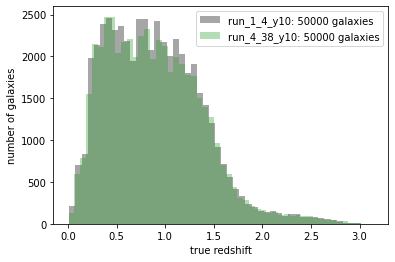

In [6]:
for os in available_os:
    plt.hist(catalogs[os]["z_true"], bins=50, alpha=0.35, color=os_colors[os],
             label=f"{os}: {len(catalogs[os])} galaxies")
    
plt.xlabel("true redshift")
plt.ylabel("number of galaxies")
plt.legend()
plt.show()

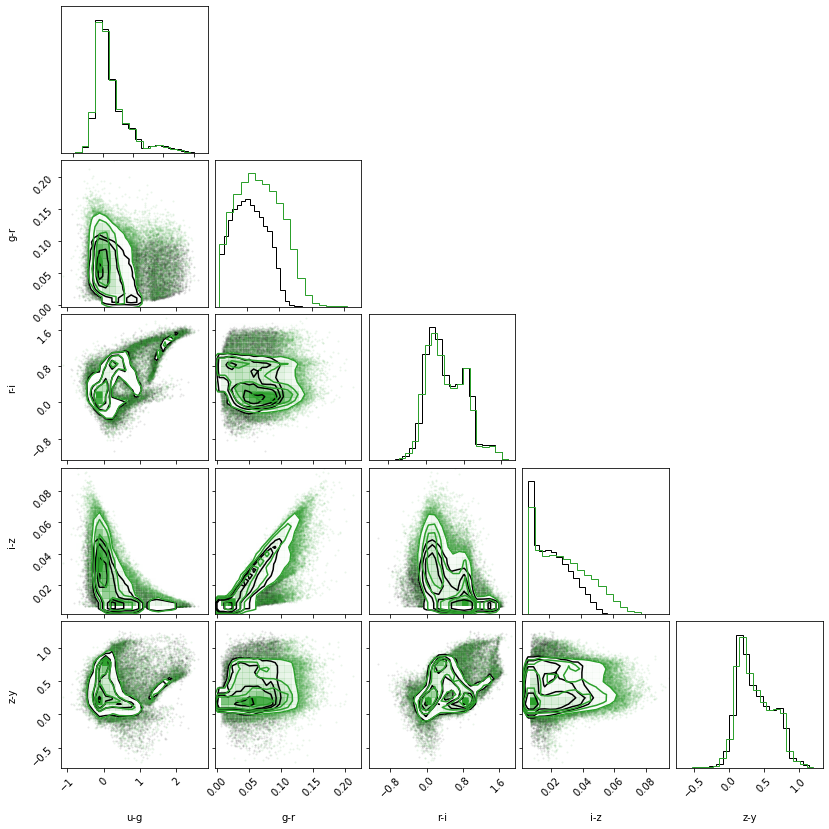

In [7]:
fig = plt.figure(figsize=(12, 12))

labels = ["u-g", "g-r", "r-i", "i-z", "z-y"]
for os in available_os:
    corner.corner(catalogs[os][labels], fig=fig, labels=labels, color=os_colors[os])

## Train a conditional flow

We use `pzflow` to learn $p(z | ugrizy)$

In [8]:
# first I create a bijector chain

# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
# I set the mean and std so that it maps the redshift range (0, 3) onto (-5, 5), which is the 
# domain of the NeuralSplineCoupling

# the second bijection is a NeuralSplineCoupling. I set its domain to (-5, 5)
# and told it to expect 5 conditions, which will be the r mag and the galaxy colors
bijector = Chain(
    StandardScaler(np.atleast_1d(3/2), np.atleast_1d(3/10)),
    NeuralSplineCoupling(B=5, n_conditions=6)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform((-5, 5))


flows = dict()
for os in available_os:
    
    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]
    
    # I create a function that will standard scale the conditions before giving them to the flow
    mean = catalogs[os][conditional_columns].mean()
    std = catalogs[os][conditional_columns].std()
    def condition_scaler(data):
        scaled_data = data.copy()
        scaled_data[conditional_columns] = (data[conditional_columns] - mean) / std
        return scaled_data
    
    # save some info with the flow
    info = {"description": f"Trained on galaxies from os {os}.",
            "condition_scaler": condition_scaler}

    # instantiate and save the flow
    flow = Flow(data_columns = data_columns, 
                conditional_columns = conditional_columns,
                bijector = bijector,
                latent = latent,
                info = info)
    
    flows[os] = flow

Now let's train each flow

In [9]:
%%time
losses = dict()
for os in available_os:
    print(f"Training flow for {os}")
    loss = flows[os].train(flows[os].info["condition_scaler"](catalogs[os]), epochs=100, verbose=False)
    losses[os] = loss

Training flow for run_1_4_y10
Training flow for run_4_38_y10
CPU times: user 1min 28s, sys: 1min 12s, total: 2min 41s
Wall time: 1min 5s


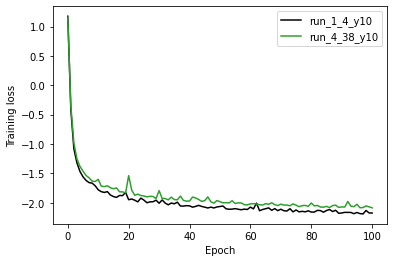

In [10]:
for os in available_os:
    plt.plot(losses[os], c=os_colors[os], label=os)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.legend()
plt.show()

To calculate log_probs, use `flow.log_prob(flow.info["condition_scaler"](data))` where data is a data frame that has columns for `z_true, r, u-g, g-r, r-i, i-z, z-y` (note that `z_true` is the true redshift, not the true z band magnitude).

In [21]:
for os in available_os:
    file_name = f"trained_flows/flow_for_{os}.pkl"
    flows[os].save(file_name)